In [28]:
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner, default_linear_learner
from ngboost.scores import MLE
from ngboost.distns import Normal, LogNormal

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import optuna 
from functools import partial

### データの準備

In [2]:
# データのロード
X, Y = load_boston(True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

### Baseの選択

In [29]:
%%time
# 決定木
ngb = NGBRegressor(Base=default_tree_learner).fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, Y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_test.flatten()).mean()
print('Test NLL', test_NLL)

[iter 0] loss=3.6308 val_loss=0.0000 scale=0.5000 norm=3.3391
[iter 100] loss=3.0765 val_loss=0.0000 scale=1.0000 norm=3.7826
[iter 200] loss=2.6941 val_loss=0.0000 scale=1.0000 norm=2.4655
[iter 300] loss=2.3912 val_loss=0.0000 scale=1.0000 norm=1.9790
[iter 400] loss=2.1666 val_loss=0.0000 scale=1.0000 norm=1.7340
Test MSE 7.73246484357078
Test NLL 2.4126845684258638
Wall time: 2.27 s


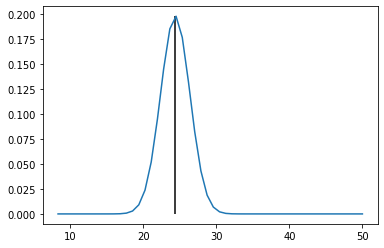

In [30]:
y_range = np.linspace(min(Y_test), max(Y_test)).reshape((-1, 1))
dist_values = Y_dists.pdf(y_range).transpose()

no = 8
plt.plot(y_range,dist_values[no])
plt.vlines(Y_preds[no],0,max(dist_values[no]))

plt.show()

In [73]:
%%time
# Ridge
ngb = NGBRegressor(Base=default_linear_learner).fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, Y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_test.flatten()).mean()
print('Test NLL', test_NLL)

[iter 0] loss=3.6308 val_loss=0.0000 scale=0.5000 norm=3.3391
[iter 100] loss=3.1727 val_loss=0.0000 scale=1.0000 norm=4.1789
[iter 200] loss=2.9399 val_loss=0.0000 scale=1.0000 norm=3.4768
[iter 300] loss=2.8668 val_loss=0.0000 scale=1.0000 norm=3.4169
[iter 400] loss=2.8522 val_loss=0.0000 scale=0.5000 norm=1.7109
Test MSE 22.085885214512665
Test NLL 2.875942074871781
Wall time: 1.82 s


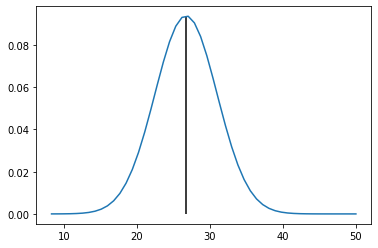

In [74]:
y_range = np.linspace(min(Y_test), max(Y_test)).reshape((-1, 1))
dist_values = Y_dists.pdf(y_range).transpose()

no = 8
plt.plot(y_range,dist_values[no])
plt.vlines(Y_preds[no],0,max(dist_values[no]))

plt.show()

### ハイパーパラメータを色々回してみる

In [77]:
# optunaで最適化のために一連の処理を関数化
def objectives(X_train, Y_train, trial):
    # scikit-learnでお試しデータの準備
    X, Y = load_boston(True)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    # optunaでのハイパーパラメータサーチ範囲の設定
    
    params = {
        # 固定パラメータ
        'Dist':Normal,
        'Score':MLE(),
        #'Base':default_tree_learner,
        'natural_gradient':True,
        'learning_rate':0.01,
        'verbose':True,
        'verbose_eval':100,
        'tol':1e-4,
        
        # サーチパラメータ
        'Base':trial.suggest_categorical('Base', [default_tree_learner, default_linear_learner]),
        'n_estimators': trial.suggest_int('n_estimators', 100,800),
        'minibatch_frac':trial.suggest_discrete_uniform('minibatch_frac', 0.1, 1.0, 0.1),
    }
 

    # 学習+予測
    model = NGBRegressor(**params)# 検討するハイパーパラメータを指定
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # テストデータを用いた評価
    score = mean_squared_error(y_pred, y_test)
    
    print(score)
    
    return score

In [78]:
# optunaによる最適化呼び出し
f = partial(objectives, X_train, Y_train)
opt = optuna.create_study(direction='minimize')# scoreの最小化を目指す。
opt.optimize(f, n_trials=10)

[iter 0] loss=3.5322 val_loss=0.0000 scale=0.5000 norm=3.0052
[iter 100] loss=3.0222 val_loss=0.0000 scale=1.0000 norm=3.5822
[iter 200] loss=2.6467 val_loss=0.0000 scale=1.0000 norm=2.4293
[iter 300] loss=2.3493 val_loss=0.0000 scale=1.0000 norm=1.8918
[iter 400] loss=2.1073 val_loss=0.0000 scale=1.0000 norm=1.6512
[iter 500] loss=1.9696 val_loss=0.0000 scale=1.0000 norm=1.5769
8.063370444775725


[I 2019-12-15 01:41:00,883] Finished trial#0 resulted in value: 8.063370444775725. Current best value is 8.063370444775725 with parameters: {'Base': <function default_tree_learner at 0x0000013D0EA41E58>, 'n_estimators': 502, 'minibatch_frac': 0.7000000000000001}.


[iter 0] loss=3.7032 val_loss=0.0000 scale=0.5000 norm=3.4064
[iter 100] loss=3.0644 val_loss=0.0000 scale=1.0000 norm=3.7398
[iter 200] loss=2.6996 val_loss=0.0000 scale=1.0000 norm=2.5672
[iter 300] loss=2.3901 val_loss=0.0000 scale=1.0000 norm=2.0119
8.322583558322583


[I 2019-12-15 01:41:02,362] Finished trial#1 resulted in value: 8.322583558322583. Current best value is 8.063370444775725 with parameters: {'Base': <function default_tree_learner at 0x0000013D0EA41E58>, 'n_estimators': 502, 'minibatch_frac': 0.7000000000000001}.


[iter 0] loss=3.6397 val_loss=0.0000 scale=0.5000 norm=3.4026
[iter 100] loss=3.0910 val_loss=0.0000 scale=1.0000 norm=3.7841
[iter 200] loss=2.7135 val_loss=0.0000 scale=1.0000 norm=2.4606
[iter 300] loss=2.3938 val_loss=0.0000 scale=1.0000 norm=1.9223
15.918140271682388


[I 2019-12-15 01:41:04,150] Finished trial#2 resulted in value: 15.918140271682388. Current best value is 8.063370444775725 with parameters: {'Base': <function default_tree_learner at 0x0000013D0EA41E58>, 'n_estimators': 502, 'minibatch_frac': 0.7000000000000001}.


[iter 0] loss=3.5568 val_loss=0.0000 scale=0.5000 norm=3.1075
[iter 100] loss=3.1845 val_loss=0.0000 scale=1.0000 norm=4.2239
[iter 200] loss=2.8651 val_loss=0.0000 scale=1.0000 norm=3.2274
[iter 300] loss=2.7999 val_loss=0.0000 scale=0.5000 norm=1.6472
34.36524806404912


[I 2019-12-15 01:41:05,414] Finished trial#3 resulted in value: 34.36524806404912. Current best value is 8.063370444775725 with parameters: {'Base': <function default_tree_learner at 0x0000013D0EA41E58>, 'n_estimators': 502, 'minibatch_frac': 0.7000000000000001}.


[iter 0] loss=3.6371 val_loss=0.0000 scale=0.5000 norm=3.3631
[iter 100] loss=3.1057 val_loss=0.0000 scale=1.0000 norm=3.9150
[iter 200] loss=2.7221 val_loss=0.0000 scale=1.0000 norm=2.5370
[iter 300] loss=2.3990 val_loss=0.0000 scale=1.0000 norm=1.9539
[iter 400] loss=2.1525 val_loss=0.0000 scale=1.0000 norm=1.7050
[iter 500] loss=1.9837 val_loss=0.0000 scale=1.0000 norm=1.5783
6.058323070248742


[I 2019-12-15 01:41:07,950] Finished trial#4 resulted in value: 6.058323070248742. Current best value is 6.058323070248742 with parameters: {'Base': <function default_tree_learner at 0x0000013D0EA41E58>, 'n_estimators': 567, 'minibatch_frac': 0.9}.


[iter 0] loss=3.6542 val_loss=0.0000 scale=0.5000 norm=3.3851
[iter 100] loss=3.0966 val_loss=0.0000 scale=1.0000 norm=3.8774
14.429678379896751


[I 2019-12-15 01:41:08,838] Finished trial#5 resulted in value: 14.429678379896751. Current best value is 6.058323070248742 with parameters: {'Base': <function default_tree_learner at 0x0000013D0EA41E58>, 'n_estimators': 567, 'minibatch_frac': 0.9}.


[iter 0] loss=3.7570 val_loss=0.0000 scale=0.5000 norm=3.5821
[iter 100] loss=3.0971 val_loss=0.0000 scale=1.0000 norm=3.7369
[iter 200] loss=2.9510 val_loss=0.0000 scale=1.0000 norm=3.6081
[iter 300] loss=2.8610 val_loss=0.0000 scale=0.5000 norm=1.7817
[iter 400] loss=2.7917 val_loss=0.0000 scale=0.5000 norm=1.6142
27.62396342374021


[I 2019-12-15 01:41:10,465] Finished trial#6 resulted in value: 27.62396342374021. Current best value is 6.058323070248742 with parameters: {'Base': <function default_tree_learner at 0x0000013D0EA41E58>, 'n_estimators': 567, 'minibatch_frac': 0.9}.


[iter 0] loss=3.6484 val_loss=0.0000 scale=0.5000 norm=3.4067
[iter 100] loss=3.2021 val_loss=0.0000 scale=1.0000 norm=4.2220
[iter 200] loss=2.9713 val_loss=0.0000 scale=1.0000 norm=3.7269
[iter 300] loss=2.8407 val_loss=0.0000 scale=1.0000 norm=3.3496
[iter 400] loss=2.7986 val_loss=0.0000 scale=1.0000 norm=3.2614
[iter 500] loss=2.8332 val_loss=0.0000 scale=0.5000 norm=1.7308
21.313669680506564


[I 2019-12-15 01:41:12,378] Finished trial#7 resulted in value: 21.313669680506564. Current best value is 6.058323070248742 with parameters: {'Base': <function default_tree_learner at 0x0000013D0EA41E58>, 'n_estimators': 567, 'minibatch_frac': 0.9}.


[iter 0] loss=3.6769 val_loss=0.0000 scale=0.5000 norm=3.5010
[iter 100] loss=3.0503 val_loss=0.0000 scale=1.0000 norm=3.6513
[iter 200] loss=2.7300 val_loss=0.0000 scale=1.0000 norm=2.8393
14.964761046938948


[I 2019-12-15 01:41:13,419] Finished trial#8 resulted in value: 14.964761046938948. Current best value is 6.058323070248742 with parameters: {'Base': <function default_tree_learner at 0x0000013D0EA41E58>, 'n_estimators': 567, 'minibatch_frac': 0.9}.


[iter 0] loss=3.6415 val_loss=0.0000 scale=0.5000 norm=3.2843
[iter 100] loss=3.1718 val_loss=0.0000 scale=1.0000 norm=4.3080
[iter 200] loss=2.9422 val_loss=0.0000 scale=1.0000 norm=3.4417
[iter 300] loss=2.8481 val_loss=0.0000 scale=1.0000 norm=3.4777
[iter 400] loss=2.8057 val_loss=0.0000 scale=0.5000 norm=1.6570
24.760698221577833


[I 2019-12-15 01:41:15,028] Finished trial#9 resulted in value: 24.760698221577833. Current best value is 6.058323070248742 with parameters: {'Base': <function default_tree_learner at 0x0000013D0EA41E58>, 'n_estimators': 567, 'minibatch_frac': 0.9}.


In [79]:
# 実行結果表示 最適パラメータ格納
params_best = {
        # 固定パラメータ
        'Dist':Normal,
        'Score':MLE(),
        'Base':default_tree_learner,
        'natural_gradient':True,
        'learning_rate':0.01,
        'verbose':True,
        'verbose_eval':100,
        'tol':1e-4,
        
        # サーチパラメータ
        'n_estimators':1,
        'minibatch_frac':1,    
    }

print('最終トライアル回数: {}'.format(len(opt.trials)))
print('ベストトライアル:')
trial = opt.best_trial
print('値: {}'.format(trial.value))
print('パラメータ:')
for key, value in trial.params.items():
    params_best[key] = value
    print('{}: {}'.format(key, value))

最終トライアル回数: 10
ベストトライアル:
値: 6.058323070248742
パラメータ:
Base: <function default_tree_learner at 0x0000013D0EA41E58>
n_estimators: 567
minibatch_frac: 0.9


In [80]:
ngb = NGBRegressor(**params_best).fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, Y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_test.flatten()).mean()
print('Test NLL', test_NLL)

[iter 0] loss=3.6183 val_loss=0.0000 scale=0.5000 norm=3.3180
[iter 100] loss=3.0721 val_loss=0.0000 scale=1.0000 norm=3.7667
[iter 200] loss=2.6900 val_loss=0.0000 scale=1.0000 norm=2.4780
[iter 300] loss=2.3912 val_loss=0.0000 scale=1.0000 norm=2.0075
[iter 400] loss=2.1644 val_loss=0.0000 scale=1.0000 norm=1.7488
[iter 500] loss=1.9856 val_loss=0.0000 scale=1.0000 norm=1.5696
Test MSE 6.816194258393561
Test NLL 2.401987849219012
